In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-b475155b-bbba-4ff0-870f-ba74738d9ed8',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '1ls3Z7jCl6h8x6Bwm91ZbZsRGbCBg7PzamaXhOGqRWkO'
}

configuration_name = 'os_92fcb5354ce74da3be6f2563692e642a_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-wdfnofq36jg14o'))
# df_data_1.take(5)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200325042410-0001
KERNEL_ID = 1c7481be-a4d1-45f0-8b97-eb648c2b28b8


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, LongType
from pyspark.sql.functions import desc, explode, udf, lit, col, isnull, avg, min, max, stddev, split, concat
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
from time import time

In [3]:
spark = SparkSession.builder.appName("Sparkify-Project").getOrCreate()

### Load and Clean Dataset
In this workspace, the mini-dataset file is mini_sparkify_event_data.json. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-wdfnofq36jg14o'))
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

**What does the schema look like**

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.count()

543705

In [8]:
#What does the userId column look like?
df.select('userId').show(10)

+------+
|userId|
+------+
|   293|
|    98|
|   179|
|   179|
|   246|
|   163|
|      |
|      |
|      |
|      |
+------+
only showing top 10 rows



Top 10 rows show there are a lot of duplicate userIds which could come from different login sessions of number of music a user is streaming

In [9]:
# Are there non-registered users with NAN userId values
# filter for users with blank user id
reg_users = df.filter(df.userId!="")
reg_users.count()

528005

In [10]:
#Drop NaN values in userIds
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

543705

### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

#### Define Churn
Once you've done some preliminary analysis, create a column Churn to use as the label for your model. I suggest using the Cancellation Confirmation events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the Downgrade events.

#### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**What are the available pages on the platform?**

In [11]:
all_pages = df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



What classes of Gender do we have in the dataset?


df_gender = df.select('gender').dropDuplicates().show()
df_gender

From the users' inputs, there are 3 classes of gender in the data. Female, male and those who didn't enter any information. May be because they are gender-neutral.

In [12]:
df.createOrReplaceTempView("event_table")

In [13]:
spark.sql("SELECT COUNT(DISTINCT userId) from event_table WHERE gender = 'F'").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   198|
+----------------------+



In [14]:
spark.sql("SELECT COUNT(DISTINCT userId) from event_table WHERE gender = 'M'").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   250|
+----------------------+



To get a good summary of this dataset, I'll convert it to pandas dataframe.

In [15]:
df_pandas = df.toPandas()

In [16]:
df_pandas.describe(include='all')

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
count,432877,543705,528005,528005,543705.000000,528005,432877.000000,543705,528005,543705,543705,5.280050e+05,543705.000000,432877,543705.000000,5.437050e+05,528005,543705
unique,21247,4,345,2,NaN,275,NaN,2,192,2,22,NaN,NaN,80292,NaN,NaN,71,449
top,Kings Of Leon,Logged In,Joseph,M,NaN,Reed,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,NaN,NaN,You're The One,NaN,NaN,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",
freq,3497,527906,13108,302612,NaN,12767,NaN,428597,40156,495143,432877,NaN,NaN,2219,NaN,NaN,46082,15700
mean,NaN,NaN,NaN,NaN,107.306291,NaN,248.664593,NaN,NaN,NaN,NaN,1.535523e+12,2040.814353,NaN,210.018291,1.540965e+12,NaN,NaN
std,NaN,NaN,NaN,NaN,116.723508,NaN,98.412670,NaN,NaN,NaN,NaN,3.078725e+09,1434.338931,NaN,31.471919,1.482057e+09,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,0.783220,NaN,NaN,NaN,NaN,1.509854e+12,1.000000,NaN,200.000000,1.538352e+12,NaN,NaN
25%,NaN,NaN,NaN,NaN,26.000000,NaN,199.392200,NaN,NaN,NaN,NaN,1.534368e+12,630.000000,NaN,200.000000,1.539720e+12,NaN,NaN
50%,NaN,NaN,NaN,NaN,68.000000,NaN,234.004440,NaN,NaN,NaN,NaN,1.536556e+12,1968.000000,NaN,200.000000,1.541005e+12,NaN,NaN
75%,NaN,NaN,NaN,NaN,147.000000,NaN,276.793020,NaN,NaN,NaN,NaN,1.537612e+12,3307.000000,NaN,200.000000,1.542177e+12,NaN,NaN


The top song is "You're the One" by the artist "King Of Leon". This song has been played 3497 times. This song is usually found from the page "Next Song". This song is the favorite song for the user with userId=92 and usually played on a Mac computer with the name Joseph Reed.

I think this is too revealing.

In [17]:
df_pandas.describe()

,itemInSession,length,registration,sessionId,status,ts
count,543705.000000,432877.000000,5.280050e+05,543705.000000,543705.000000,5.437050e+05
mean,107.306291,248.664593,1.535523e+12,2040.814353,210.018291,1.540965e+12
std,116.723508,98.412670,3.078725e+09,1434.338931,31.471919,1.482057e+09
min,0.000000,0.783220,1.509854e+12,1.000000,200.000000,1.538352e+12
25%,26.000000,199.392200,1.534368e+12,630.000000,200.000000,1.539720e+12
50%,68.000000,234.004440,1.536556e+12,1968.000000,200.000000,1.541005e+12
75%,147.000000,276.793020,1.537612e+12,3307.000000,200.000000,1.542177e+12
max,1005.000000,3024.665670,1.543074e+12,4808.000000,404.000000,1.543622e+12


In [18]:
df_pandas.tail(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
543695,Reel Big Fish,Logged In,Jeremiah,M,30,Jenkins,190.69342,paid,"Memphis, TN-MS-AR",PUT,NextSong,1.536229e+12,916,Ban The Tube Top,200,1543622178000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300039
543696,Westside Connection,Logged In,Daniel,M,144,Stewart,148.08771,paid,"Fresno, CA",PUT,NextSong,1.537523e+12,991,Terrorist Threats (Edited),200,1543622184000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049
543697,Cracker,Logged In,Aiden,M,34,Reed,205.03465,paid,"Lakeland-Winter Haven, FL",PUT,NextSong,1.535616e+12,966,I'm A Little Rocket Ship,200,1543622187000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300038
543698,None,Logged In,Aiden,M,35,Reed,NaN,paid,"Lakeland-Winter Haven, FL",GET,Home,1.535616e+12,966,None,200,1543622227000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300038
543699,The Morning Benders,Logged In,Joshua,M,108,White,104.12363,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1.528781e+12,981,Cold War,200,1543622297000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015
543700,Oliver Onions,Logged In,Clayton,M,165,Jackson,183.50975,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1.536850e+12,882,Dune Buggy,200,1543622316000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300010
543701,Sheena Easton,Logged In,Daniel,M,145,Stewart,239.62077,paid,"Fresno, CA",PUT,NextSong,1.537523e+12,991,Strut (1993 Digital Remaster),200,1543622332000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",300049
543702,The White Stripes,Logged In,Jeremiah,M,31,Jenkins,234.97098,paid,"Memphis, TN-MS-AR",PUT,NextSong,1.536229e+12,916,Jolene [Live],200,1543622368000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",300039
543703,Hinder,Logged In,Aiden,M,36,Reed,262.05995,paid,"Lakeland-Winter Haven, FL",PUT,NextSong,1.535616e+12,966,Lips Of An Angel,200,1543622392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300038
543704,Jack Johnson,Logged In,Joshua,M,109,White,144.06485,paid,"San Antonio-New Braunfels, TX",PUT,NextSong,1.528781e+12,981,Do You Remember,200,1543622401000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",300015


In [19]:
#What's the distribution of users' auth ()
df.groupBy("auth").count().orderBy("auth").show()


+----------+------+
|      auth| count|
+----------+------+
| Cancelled|    99|
|     Guest|    94|
| Logged In|527906|
|Logged Out| 15606|
+----------+------+



In [20]:
#What's the users' gender distribution 
df.groupBy("gender").count().orderBy("gender").show()

+------+------+
|gender| count|
+------+------+
|  null| 15700|
|     F|225393|
|     M|302612|
+------+------+



In [21]:
#How many users are using the Free version or Paid Subscription
df.groupBy("level").count().orderBy("level").show()

+-----+------+
|level| count|
+-----+------+
| free|115108|
| paid|428597|
+-----+------+



### Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

1. Write a script to extract the necessary features from the smaller subset of data
2. Ensure that your script is scalable, using the best practices discussed in Lesson 3
3. Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Which Users Downgraded their account or Cancelled their Subscriptions?

In [22]:
df.filter("page = 'Submit Downgrade'").count()

117

In [23]:
cancel = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
cancel.count()

99

#### Calculate Statistics by Hour

In [24]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [25]:
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293', hour='0')

In [26]:
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour)

In [27]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|17555|
|   1|17038|
|  10|15476|
|  11|16290|
|  12|17230|
|  13|17995|
|  14|19978|
|  15|21953|
|  16|22542|
|  17|22500|
|  18|22223|
|  19|21296|
|   2|16265|
|  20|20336|
|  21|19850|
|  22|19191|
|  23|18327|
|   3|15581|
|   4|15430|
|   5|15203|
+----+-----+
only showing top 20 rows



In [28]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

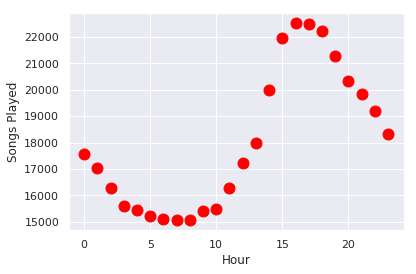

In [29]:
sb.set()
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"], s=120, c='red')
plt.xlabel("Hour")
plt.ylabel("Songs Played");

#### Churn Rate

In [30]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_churn = df.withColumn("churn", df.userId.isin(churn_users_list))

Compare the number of churned users to the users who didn't change their accounts

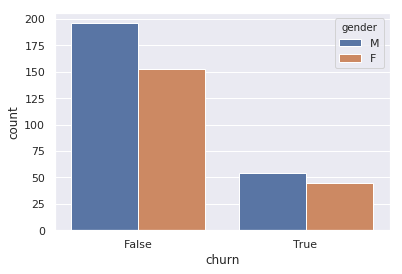

In [31]:
churn_by_gender = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sb.barplot(x='churn', y='count', hue='gender', data=churn_by_gender)

**At what level were the users before they churned?**

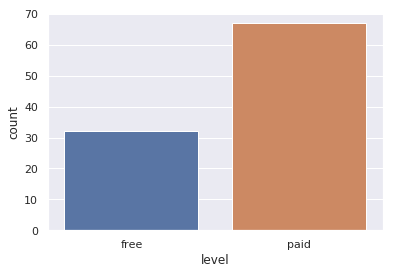

In [32]:
df_churnlevel = df_churn.filter(df_churn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sb.barplot(x="level", y="count", data=df_churnlevel)

#### Create Features from the Churned Customers/Users

For predicting the churn rate, we have to look at different features and user behaviors by extracting the features below.

1. Total songs a user listened to: Were the users actively engaged? 
2. Total Number of Artist listened to: What variety of the songs did the users interact with? 
3. Listening time statistics (average, min and max time per session): Each time a use logs in, how long did they stay on theplatform before logging out? This will show if they really like the platform. 
4. Total songs listened to per session 
5. How many songs did they like (Thumbs Up) 6. How many songs did they dislike (Thumbs Down) 
6. Number of songs added to playlist 
7. How many friends each user added:Will there will peer pressure influencing decisions by users? 
8. What's the Gender Distribution: The behavior of the female users may be different from that of the male users as seen from the exploratory analysis of the gender 
9. Churn rate 
10. Time spent on the platform: How long has a user been registered on the platform.

**-->> Merge all features and labels**

**F1: Total songs a churned user listened to**

In [33]:
f1 = df_churn \
    .filter(df_churn.page=="NextSong") \
    .groupby("userId", "song") \
    .count() \
    .withColumnRenamed("count", "num_songs")
    
    
f1.describe().show()

+-------+------------------+--------------------+------------------+
|summary|            userId|                song|         num_songs|
+-------+------------------+--------------------+------------------+
|  count|            381808|              381808|            381808|
|   mean|59287.684294200226|            Infinity|1.1337557096760675|
| stddev| 108973.0898515188|                 NaN|0.6789142627704061|
|    min|                10|ÃÂg ÃÂtti Gr...|                 1|
|    max|                99|ÃÂ¾etta Gerist Ã...|                49|
+-------+------------------+--------------------+------------------+



**F2: Total Number of Artist Listened To**

In [34]:
f2 = df_churn \
    .filter(df_churn.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_artist")
    
f2.describe().show()

+-------+------------------+-----------------+
|summary|            userId|       num_artist|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|658.9799107142857|
| stddev|105964.58428485181| 625.882698051957|
|    min|                10|                1|
|    max|                99|             3507|
+-------+------------------+-----------------+



**F3: Listening time statistics per session**

In [35]:
f3 = df_churn \
    .filter(df_churn.page=="NextSong") \
    .groupby("userId", "sessionId") \
    .count() \
    .withColumnRenamed("count", "songs_played")

f3.describe().show()

+-------+------------------+------------------+-----------------+
|summary|            userId|         sessionId|     songs_played|
+-------+------------------+------------------+-----------------+
|  count|              5921|              5921|             5921|
|   mean| 70318.23712210775|1806.3252828914035| 73.1087654112481|
| stddev|114146.67821720056|1433.4717443355146|88.38790231810648|
|    min|                10|                 1|                1|
|    max|                99|              4808|              810|
+-------+------------------+------------------+-----------------+



**F4: How many songs did they like (Thumbs Up)**

In [36]:
f4 = df_churn \
    .filter(df_churn.page=="Thumbs Up") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_thumbs_up")
    
f4.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    num_thumbs_up|
+-------+------------------+-----------------+
|  count|               439|              439|
|   mean| 67308.81548974942|54.27334851936219|
| stddev|106228.80408254791| 69.9413517877898|
|    min|                10|                1|
|    max|                99|              506|
+-------+------------------+-----------------+



**F5: Number of Thumbs Down Given by user**

In [37]:
f5 = df_churn \
    .filter(df_churn.page=="Thumbs Down") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_thumbs_down") 

f5.describe().show()

+-------+------------------+------------------+
|summary|            userId|   num_thumbs_down|
+-------+------------------+------------------+
|  count|               389|               389|
|   mean| 70031.19537275065|12.624678663239074|
| stddev|106895.73735311364|13.582432851937986|
|    min|                10|                 1|
|    max|                99|                80|
+-------+------------------+------------------+



**F6: Number of songs added to playlist**

In [38]:
f6 = df_churn \
    .filter(df_churn.page=="Add to Playlist") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_playlist")

f6.describe().show()

+-------+-----------------+------------------+
|summary|           userId|      num_playlist|
+-------+-----------------+------------------+
|  count|              428|               428|
|   mean|65764.93457943926|28.852803738317757|
| stddev| 105363.385783828| 33.91309069456631|
|    min|               10|                 1|
|    max|               99|               248|
+-------+-----------------+------------------+



**F7: Number of Friends User Added**

In [39]:
f7 = df_churn \
    .filter(df_churn.page=="Add Friend") \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_friends") 

f7.describe().show()

+-------+----------------+------------------+
|summary|          userId|       num_friends|
+-------+----------------+------------------+
|  count|             409|               409|
|   mean|66368.3716381418|19.772616136919314|
| stddev|106064.016090306|22.494435766272826|
|    min|              10|                 1|
|    max|              99|               158|
+-------+----------------+------------------+



**F8: Gender distribution**

In [46]:
f8 = df_churn \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(["M", "F"], ["0", "1"], "gender")

f8 = f8.select("userId", f8.gender.cast("int"))
f8.show(5)

+------+------+
|userId|gender|
+------+------+
|   188|     1|
|   234|     0|
|    44|     1|
|   273|     0|
|    46|     1|
+------+------+
only showing top 5 rows



**F9: Churn rate**

In [41]:
f9_label = df_churn \
    .select('userId', col('churn').alias('label').cast('int')) \
    .dropDuplicates() 

f9_label.show()

+------+-----+
|userId|label|
+------+-----+
|    19|    0|
|    73|    0|
|   209|    0|
|100005|    1|
|100030|    1|
|100034|    0|
|200007|    0|
|   184|    0|
|    50|    0|
|100048|    1|
|    30|    0|
|100011|    1|
|100012|    1|
|300051|    0|
|   172|    1|
|     8|    0|
|   192|    0|
|   214|    1|
|   211|    0|
|     4|    0|
+------+-----+
only showing top 20 rows



**F10: How long has the user been a registered member on the platform**

In [42]:
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('activity_time', convert_ts('ts'))
df = df.withColumn('registration_time', convert_ts('registration'))

In [43]:
f10 = df_churn \
    .select('userId', 'registration', 'ts') \
    .withColumn('time_registered(days)', (df_churn.registration)) \
    .groupBy('userId') \
    .agg({"time_registered(days)" : "max"}) \
    .withColumnRenamed('max(time_registered(days))', 'time_registered(days)') \
    .select('userId', (col('time_registered(days)')/1000/3600/24).alias('time_registered(days)')) 

f10.describe().show()

+-------+------------------+---------------------+
|summary|            userId|time_registered(days)|
+-------+------------------+---------------------+
|  count|               449|                  448|
|   mean| 67520.34821428571|   17770.076449497767|
| stddev|105964.58428485182|   37.598134254940724|
|    min|                  |   17475.164270833335|
|    max|                99|   17859.651319444445|
+-------+------------------+---------------------+



**Merge all the features and label**

In [47]:
merged_features = f1.join(f2,'userId','outer') \
    .join(f3,'userId','outer') \
    .join(f4,'userId','outer') \
    .join(f5,'userId','outer') \
    .join(f6,'userId','outer') \
    .join(f7,'userId','outer') \
    .join(f8,'userId','outer') \
    .join(f9_label,'userId','outer') \
    .join(f10,'userId','outer') \
    .drop('userId') \
    .fillna(0)

merged_features.show()

+--------------------+---------+----------+---------+------------+-------------+---------------+------------+-----------+------+-----+---------------------+
|                song|num_songs|num_artist|sessionId|songs_played|num_thumbs_up|num_thumbs_down|num_playlist|num_friends|gender|label|time_registered(days)|
+--------------------+---------+----------+---------+------------+-------------+---------------+------------+-----------+------+-----+---------------------+
|      Radar Detector|        1|        94|       62|          49|            4|              3|           1|          3|     1|    1|   17801.115046296294|
|      Radar Detector|        1|        94|      166|          47|            4|              3|           1|          3|     1|    1|   17801.115046296294|
|              Bionik|        1|        94|       62|          49|            4|              3|           1|          3|     1|    1|   17801.115046296294|
|              Bionik|        1|        94|      166|     

### Modeling

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Data Pre-Processing

**Vectorize the features for training, validation and testing**

In [48]:
vec_assembler = VectorAssembler(inputCols=merged_features.columns[1:-1], outputCol="NumFeatures")
merged_features = vec_assembler.transform(merged_features)

**Standardize the features**. This step takes care of values with very wide margins from the rest of the data. The data is rescaled int a certain range in order to make two different attributes to be directly comparable. This also means massaging the data into a normal range. 

This is achieved by subtracting the mean of each feature divided by each features standard deviation, `x' = (x - avg(x))/stddev`

Where `x` is the original feature vector, `avg(x)` is the mean of that feature vector, and `stddev` is its standard deviation.

**Standard Scaler**

In [50]:
std_scaler= StandardScaler(inputCol="NumFeatures", outputCol=("features"), withStd=True)
std_scaler = std_scaler.fit(merged_features)
merged_features = std_scaler.transform(merged_features)

#### Data Splitting for Modeling

Split the data for developing our model into 3 parts;train, test, validation. Use randomSplit for proper random shuffling of the data during splitting.

In [51]:
train, rest = merged_features.randomSplit([0.7, 0.3], seed=42)
test, validation = rest.randomSplit([0.5, 0.5], seed=42)

In [52]:
train.printSchema()

root
 |-- song: string (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- num_artist: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- songs_played: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_playlist: long (nullable = true)
 |-- num_friends: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- time_registered(days): double (nullable = false)
 |-- NumFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [53]:
test.printSchema()

root
 |-- song: string (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- num_artist: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- songs_played: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_playlist: long (nullable = true)
 |-- num_friends: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- time_registered(days): double (nullable = false)
 |-- NumFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [54]:
validation.printSchema()

root
 |-- song: string (nullable = true)
 |-- num_songs: long (nullable = true)
 |-- num_artist: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- songs_played: long (nullable = true)
 |-- num_thumbs_up: long (nullable = true)
 |-- num_thumbs_down: long (nullable = true)
 |-- num_playlist: long (nullable = true)
 |-- num_friends: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- time_registered(days): double (nullable = false)
 |-- NumFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



**Baseline Model**

Using binary models where all users cancel as `(churn=1)` and all users stay of the platform as `churn=0`. Performance of these 2 models will be based on their accuracy and f1-score.

In [57]:
base_0 = test.withColumn('prediction', lit(1.0))

test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Baseline evaluation:")
print("Accuracy:{}".format(test_eval.evaluate(base_0, {test_eval.metricName: "accuracy"})))
print("F-1 Score: {}".format(test_eval.evaluate(base_0, {test_eval.metricName: "f1"})))

Baseline evaluation:
Accuracy:0.18281497636238028
F-1 Score: 0.05651148531304753


In [58]:
base_1 = test.withColumn('prediction', lit(1.0))

test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Baseline evaluation:")
print("Accuracy:{}".format(test_eval.evaluate(base_1, {test_eval.metricName: "accuracy"})))
print("F-1 Score: {}".format(test_eval.evaluate(base_1, {test_eval.metricName: "f1"})))

Baseline evaluation:
Accuracy:0.18281497636238028
F-1 Score: 0.05651148531304753


### Random Forest

In [66]:
# initialize classifier
random_forest = RandomForestClassifier()

# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=4)

In [67]:
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
cvModel_rf.avgMetrics
print('Training completed after {} seconds'.format(end - start))

Training completed after 1711.9609940052032 seconds


In [61]:
result_rf = cvModel_rf.transform(validation)

In [62]:
test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Evaluation Metrics for Random Forest:")
print("Accuracy:{}".format(test_eval.evaluate(result_rf, {test_eval.metricName: "accuracy"})))
print("F-1 Score: {}".format(test_eval.evaluate(result_rf, {test_eval.metricName: "f1"})))

Evaluation Metrics for Random Forest:
Accuracy:1.0
F-1 Score: 1.0


### Logistic Regression

In [68]:
# initialize classifier
logreg = LogisticRegression(maxIter=10)

# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_logreg = CrossValidator(estimator=logreg,
                          evaluator=f1_eval, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [69]:
start = time()
cvModel_logreg = crossval_logreg.fit(train)
end = time()
cvModel_logreg.avgMetrics
print('Training completed in {} seconds'.format(end - start))

Training completed in 1323.0848052501678 seconds


In [71]:
result_logreg = cvModel_logreg.transform(validation)

test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Evaluation from Logistic Regression:')
print('Accuracy: {}'.format(test_eval.evaluate(result_logreg, {test_eval.metricName: "accuracy"})))
print('F-1 Score:{}'.format(test_eval.evaluate(result_logreg, {test_eval.metricName: "f1"})))

Evaluation from Logistic Regression:
Accuracy: 0.9999702311886484
F-1 Score:0.999970230237842


### Gradient Boosting Trees (GBT)

Gradient Boosting: GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

In [72]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=3)

In [73]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
cvModel_gbt.avgMetrics
print('Training completed in {} seconds'.format(end - start))

Training completed in 2596.5407004356384 seconds


In [74]:
result_gbt = cvModel_gbt.transform(validation)

In [75]:
test_eval = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Evaluation from Gradient Boosted Trees:')
print('Accuracy: {}'.format(test_eval.evaluate(result_gbt, {test_eval.metricName: "accuracy"})))
print('F-1 Score:{}'.format(test_eval.evaluate(result_gbt, {test_eval.metricName: "f1"})))

Evaluation from Gradient Boosted Trees:
Accuracy: 1.0
F-1 Score:1.0


The time and resources that went into training the 3 models is quiite significant.
From the 3 different models trained here, it is more beneficial and cost effective to choose the best performing model.